In [1]:
import sys # 是 Python 的內建模組，提供了與 Python 解釋器和運行環境相關的功能。
sys.path.append("/content/drive/MyDrive/Colab Notebooks/ecg-classification")

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use("ggplot") #  是 Matplotlib 庫中用於設置繪圖樣式的函數。它使用了一種名為 "ggplot" 的預定義樣式
                        #  該樣式模仿了 R 語言的 ggplot2 繪圖包的外觀。

In [2]:
# data_loader.py
from typing import Callable

import pandas as pd
import torch
import torch.utils.data as data

from ecg_tools.config import DatasetConfig, Mode


class EcgLoader(data.Dataset):

    def __init__(self, csv_file, transforms: Callable = lambda x: x) -> None:
        super().__init__()
        self.annotations = pd.read_csv(csv_file).values
        self.transforms = transforms

    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, item):
        signal = self.annotations[item, :-1]
        label = int(self.annotations[item, -1])
        # TODO: add augmentations
        signal = torch.from_numpy(signal).float()
        signal = self.transforms(signal)
        return signal.unsqueeze(0), torch.tensor(label).long()


def get_data_loaders(config: DatasetConfig):
    return {
        Mode.train: data.DataLoader(
            EcgLoader(config.path[Mode.train], config.transforms[Mode.train]),
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            shuffle=True
        ),
        Mode.eval: data.DataLoader(
            EcgLoader(config.path[Mode.eval], config.transforms[Mode.eval]),
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            shuffle=False
        )
    }

**DatasetConfig**
```python
@dataclasses.dataclass()
class DatasetConfig:
    # 載入 dataset
    # 預設 batch_size 為 64
    # batch_size: int = 64
    batch_size: int = 32
    num_workers: int = 2
    path: Dict = dataclasses.field(default_factory=lambda: {
        Mode.train: "/content/drive/MyDrive/Colab Notebooks/ecg-classification/data/mitbih_train.csv",
        Mode.eval: "/content/drive/MyDrive/Colab Notebooks/ecg-classification/data/mitbih_test.csv"
    })
    transforms: Dict = dataclasses.field(default_factory=lambda: {
        Mode.train: Compose([RandomNoise(0.05, 0.5), RandomShift(10, 0.5)]), Mode.eval: lambda x: x})

```

In [3]:
loader = get_data_loaders(DatasetConfig()) # 傳送 DatasetConfig() 的參數給 get_data_loaders
print(type(loader)) # loader 是一個 dict
print(type(loader[Mode.train])) # loader[Mode.train] 是一個 torch.utils.data.DataLoader

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [4]:
for signal, label in loader[Mode.train]:
    print(signal.size()) #
    print(signal[0].size())
    print(signal.numpy()[0, :].shape)
    break
# signal 是

torch.Size([32, 1, 187])
torch.Size([1, 187])
(1, 187)


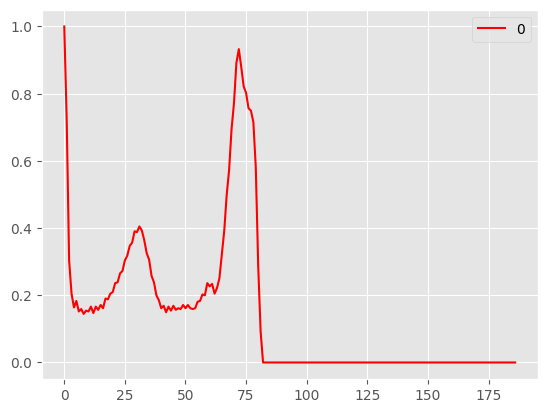

In [5]:
for signal, label in loader[Mode.train]:
    from matplotlib import pyplot as plt
    plt.style.use("ggplot")
    # 取 batch 中的第一筆資料轉成 numpy 並壓成一維畫圖
    # label 為這一筆資料的病徵
    plt.plot(signal.numpy()[0, :].flatten(), "-r", label=label[0].numpy())
    plt.legend()
    %matplotlib inline
    plt.show()
    break